<img src="./images/kaggle-hr-logo.jpg"  style="width: 300px" align="right";/>

A few weeks ago I finally signed up for [Kaggle](www.kaggle.com) and got my feet wet with a little machine learning. In this project, I analyzed [(simulated) Human Resources data](https://www.kaggle.com/ludobenistant/hr-analytics) with respect to 14,999 employees to predict (and understand) which employees would give their two weeks notice. Employee retention (or conversely, 'churn') is a key problem faced by companies, as it is significantly more expensive to find, hire, and train new employees than it is to retain current ones. Thus many (all?) employers have a clear interest in understanding why people tend to leave and to identifying those who are currently at the highest risk of leaving.




----------



# Methods
When trying to predict outcomes like churn, which have the potential to be avoided, it is often desirable to have interpretable models that can help us understand the relative importance of different employee characteristics. A black-box classifier may produce great predictions, but it may not provide any clues as to what management should try to change or address in order to retain an employee. Therefore, I will be using old fashioned logistic regression to model employee churn. My analysis will follow this course:

 1. Preliminary logistic regression to evaluate baseline prediction given the current variables, as well as estimated variable contribution to churn.
 2. Visualizations:
  - to explore relationships between employee characteristics and churn
  - to identify new features that may be useful
  - to evaluate which employees are being mis-classified by the baseline models
 3. Data pre-processing, including feature engineering
 4. Modeling, tuning, and evaluation
 5. Simulations and visualization to see how combinations of variables affect churn


In [1]:
# standard
import numpy as np
import pandas as pd

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

%matplotlib inline

# modeling
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import roc_curve, auc, classification_report, precision_recall_curve, average_precision_score
from sklearn import preprocessing
import statsmodels.api as sm

import warnings
warnings.filterwarnings('ignore')

/Users/stevenfelix/anaconda2/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [3]:
data = pd.read_csv('HR_comma_sep.csv')
orig_vars = 'Satisfaction, Evaluation, Projects, Hours, Tenure, Accident, Left, Promotion, Department, Salary'.split(', ')
data.columns = orig_vars
print(data.shape)
data.head()

(14999, 10)


,Satisfaction,Evaluation,Projects,Hours,Tenure,Accident,Left,Promotion,Department,Salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


In [4]:
def process(data):
    '''Takes in raw data frame and conducts dummy coding and recoding.
    Returns X and y'''
    y = data['Left']
    X = (data.drop(['Left'], axis = 1)
            .replace(['low','medium','high'], [1,2,3],axis=1)
            .pipe(pd.get_dummies,columns=['Department'],drop_first=True)
            #.pipe(preprocessing.scale,axis = 0)) # produces ndarray
            .apply(preprocessing.scale,axis = 0)) # produces pd.DataFrame
    return X, y

# Graphing parameters for seaborn and matplotlib
snsdict = {'axes.titlesize' : 30,
            'axes.labelsize' : 28,
            'xtick.labelsize' : 26,
            'ytick.labelsize' : 26,
            'figure.titlesize': 34}
pltdict = {'axes.titlesize' : 20,
         'axes.labelsize' : 18,
         'xtick.labelsize' : 16,
         'ytick.labelsize' : 16,
         'figure.titlesize': 24}

Note: important to include `drop_first = True` in ` pd.get_dummies`, in order to avoid multi-collinearity. Our model will include a bias term to account for this missing dummy.

----------
## Part 1: Baseline Models

Here we will run a logistic regression to get a baseline sense of prediction accuracy and variable importance. We can also use these predictions to visualize where this simple model is failing.

In [5]:
# Process and split data
X,y = process(data)
X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size = 0.1, random_state = 50)

In [6]:
## Using statsmodels for its nice output summary
logit = sm.Logit(y_train,X_train)
results = logit.fit();
print(results.summary());

Optimization terminated successfully.
         Current function value: 0.608227
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                   Left   No. Observations:                13499
Model:                          Logit   Df Residuals:                    13482
Method:                           MLE   Df Model:                           16
Date:                Wed, 26 Jul 2017   Pseudo R-squ.:                 -0.1092
Time:                        20:41:25   Log-Likelihood:                -8210.5
converged:                       True   LL-Null:                       -7402.2
                                        LLR p-value:                     1.000
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Satisfaction              -0.7570      0.021    -35.655      0.000      -0.799      

Evaluating the statistical significance (*p*-values) for the coefficients from the table,  nearly all of the variables appear to contribute meaningful information about whether an employee leaves.  Note, regarding the dummy variables,  'IT' is the withheld group, so the coefficients and their *p*-values refer to the mean difference (in odds) of leaving between IT and the specified group.  Our pseudo-R^2 is pretty small, but we'll see how much that affects our prediction accuracy.

Assuming linear relationships between probability of leaving and each of these variables, the graph below illustrates the change in odds of leaving based on a one-unit change in each variable. Note that variables were standardized, so a 'unit' change is a standard deviation. With these caveats in mind it appears the most important variables include: 

 - satisfaction,
 - tenure,
 - salary,
 - presence of a work accident
 - hours



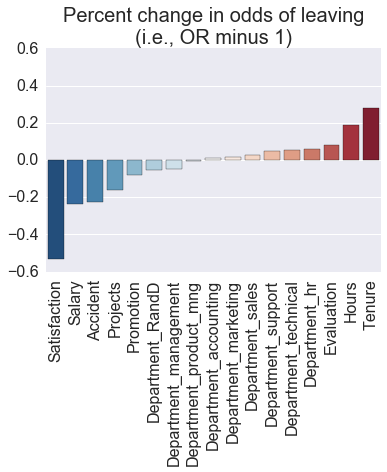

In [7]:
plt.rcParams.update(pltdict)
ORs = np.exp(results.params).sort_values();
g = sns.barplot(x = ORs.index, y = ORs-1, palette = 'RdBu_r');
g.set_xticklabels(ORs.index, rotation = 90);
g.set_title('Percent change in odds of leaving\n(i.e., OR minus 1)');
g.set_ylim(-.6, .6);

10-fold cross validation accuracy: 79.45% 


Precision/Recall Table: 

             precision    recall  f1-score   support

          0       0.82      0.93      0.87     11428
          1       0.61      0.37      0.46      3571

avg / total       0.77      0.79      0.77     14999



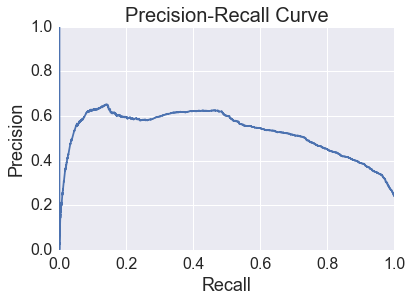

In [8]:
lr = LogisticRegression(C = 1, random_state=1)
lr.fit(X_train,y_train)
print('10-fold cross validation accuracy: {0:.2f}% \n\n'
      .format(np.mean(cross_val_score(lr, X_train, y_train,cv = 10))*100))
print('Precision/Recall Table: \n')
print(classification_report(y, lr.predict(X)))
prc = precision_recall_curve(y_train, lr.decision_function(X_train), pos_label=1);
plt.plot(prc[1],prc[0]);
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')

So, as a starting point, we're predicting with 80% accuracy. At first glance, that's not too bad! But our precision and recall metrics tell a different story. Since we're interested in accurately predicting who leaves the company, let's focus on  line '1' (the second line) from the precision/recall table .  Our precision score is only 0.61.  This means that among all of the people we predict will leave (positive predictions), only 61% of them actually do. The problem is that we're getting too many false-positives.

Our recall figure is even worse.  (In some fields, recall is also known as 'sensitivity'). Among all the people that actually left the company (i.e., the ground truth), we're identifying only 37% of them! Here we have way too many false negatives.

How could our overall accuracy be so high despite such low precision and recall? Our 80% accuracy score is likely due to the fact that we have imbalanced data. In our sample, only 24% of people leave. Thus, by simply predicting that everyone stays, we could get an overall accuracy of about 76%. The other 24% would be false negatives.

Thus, overall accuracy rates can be deceiving. (As can 'true negative' rates, a.k.a. 'specificity').

----------

## Part 2: Visualization

With the preceding context in mind, let's take a look at the data to evaluate our assumptions (e.g., linearity of Y~X relationships) and see what new features may be useful for improving precision and recall.

### Satisfaction

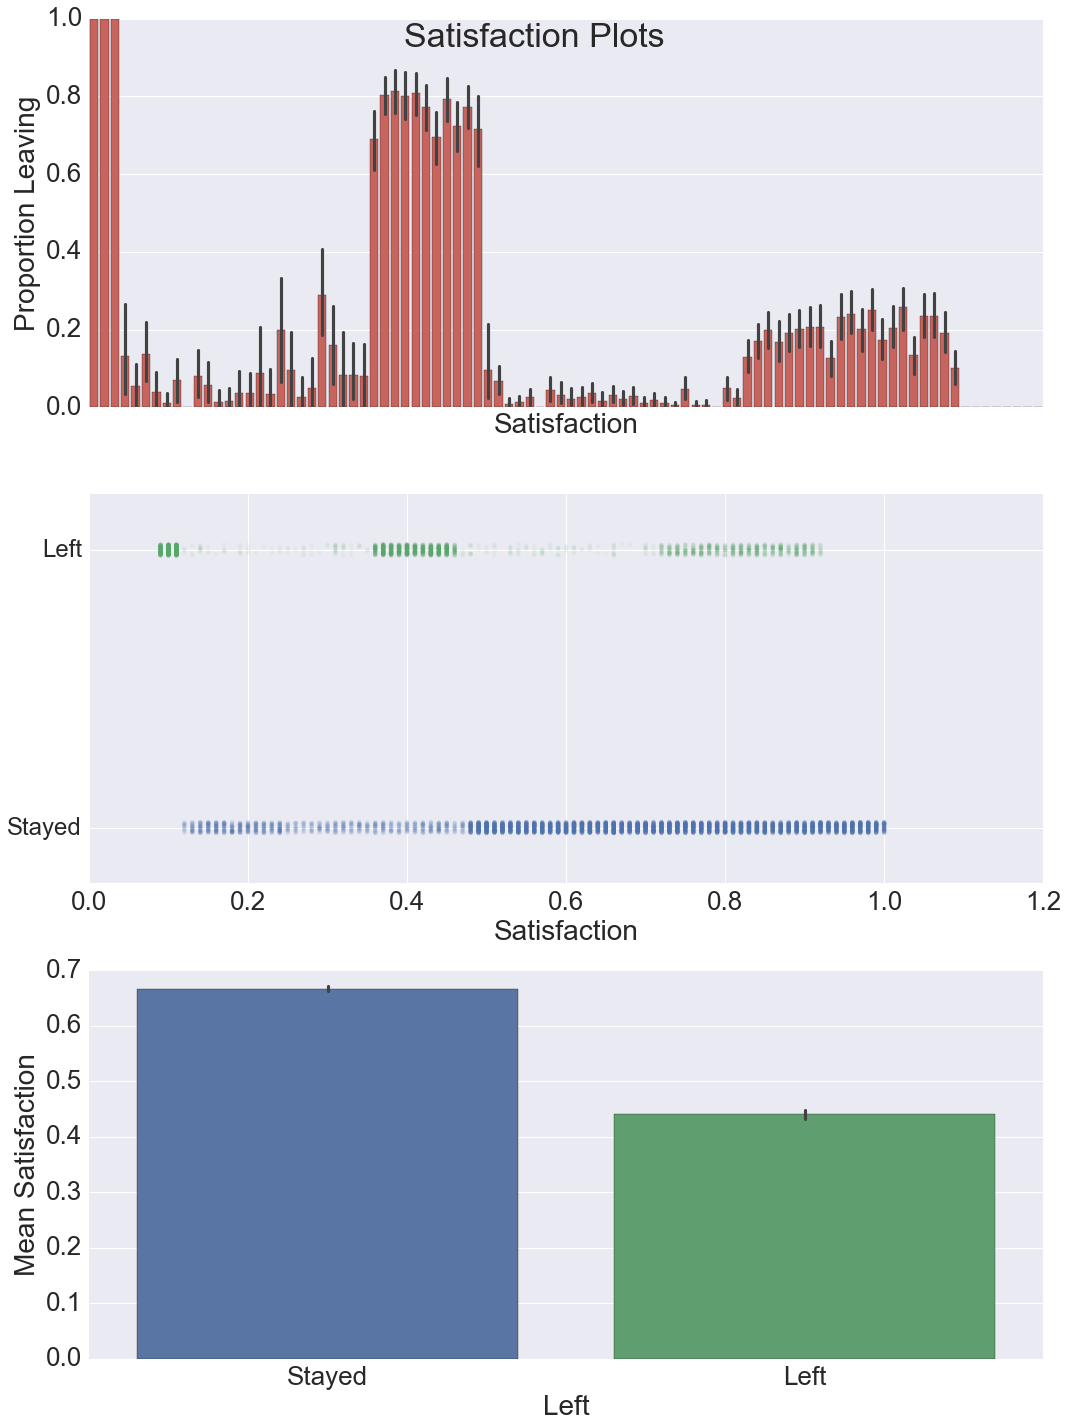

In [9]:
    # Set colors for the different groups
current_palette = sns.color_palette()[0:2]
cols = [current_palette[grp] for grp in data.Left]

sns.set(rc = snsdict)
#plt.rcParams.update(pltdict)

fig, ax = plt.subplots(3,1, figsize = (15,20));
sns.barplot(data = data, x = 'Satisfaction', y= 'Left', ax = ax[0], color = sns.xkcd_rgb["pale red"]);
sns.regplot(data = data, x = 'Satisfaction', y= 'Left', y_jitter=.02,
            scatter_kws={'alpha':0.05, 'color':cols}, fit_reg = False, ax = ax[1]);
sns.barplot(data = data, x= 'Left', y = 'Satisfaction', ax = ax[2]);
ax[0].set_ylabel("Proportion Leaving"); ax[0].set_xticks([])
ax[2].set_xticklabels(['Stayed','Left']); ax[2].set_ylabel('Mean Satisfaction');
ax[1].set_yticklabels(['Stayed','Left'], fontsize = 24); ax[1].set_ylabel('');ax[1].set_yticks([0,1]);
fig.suptitle('Satisfaction Plots')
plt.tight_layout()

Evaluating the graphs above, we notice a significant non-linearity between job satisfaction and probability of staying. People at the low and middle levels of satisfaction have high probabilities of leaving, with lower probabilities in between and around.  These patterns would be obscured if we were to look just at the bar graphs (#3 below) comparing the mean satisfaction of those who left and those who stayed. In particular, we would know very little about the employees with low-medium satisfaction levels (The chunk of people on the left of graph #1 with low probabilities of leaving).

This variable may need a third- (or even fourth) order polynomial.

### Evaluation

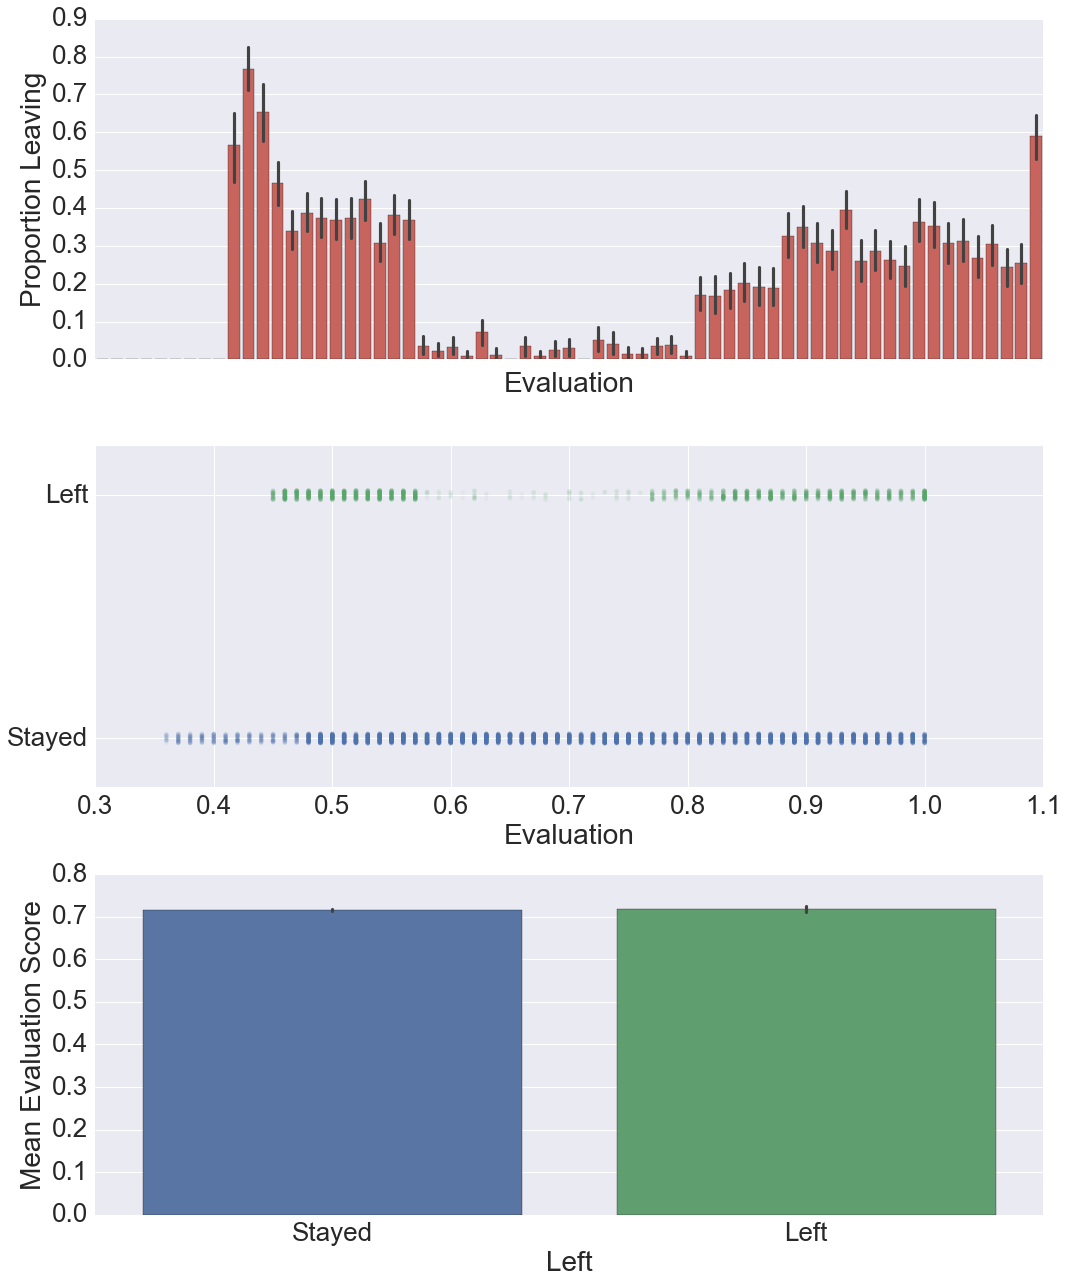

In [10]:
fig, ax = plt.subplots(3,1, figsize = (15,18));
sns.barplot(data = data, x = 'Evaluation', y= 'Left', ax = ax[0], color = sns.xkcd_rgb["pale red"]);
sns.regplot(data = data, x = 'Evaluation', y= 'Left', y_jitter=.02,
            scatter_kws={'alpha':0.05, 'color':cols}, fit_reg = False, ax = ax[1]);
sns.barplot(data = data, x= 'Left', y = 'Evaluation', ax = ax[2]);
ax[0].set_ylabel('Proportion Leaving'); ax[0].set_xticklabels([])
ax[1].set_xlabel("Evaluation"); ax[1].set_yticks([0,1]); ax[1].set_yticklabels(['Stayed','Left']);
ax[1].set_ylabel('');
ax[2].set_xticklabels(['Stayed','Left']); ax[2].set_ylabel('Mean Evaluation Score')
fig.tight_layout()

In these plots, we see very similar non-linear trends to those of "Satisfaction".  Again, mean evaluation scores (plot #3) hide the fact that the people who leave come from opposite ends of the spectrum in terms of their evaluation -- so their average is equivalent to those who stayed. A quadratic term will be appropriate to include in our model.

Also interesting to note: the odds-ratio associated with Evaluation was lower than other variables. This may be due to the fact that the relationship is non-linear.

### Evaluation X Satisfaction

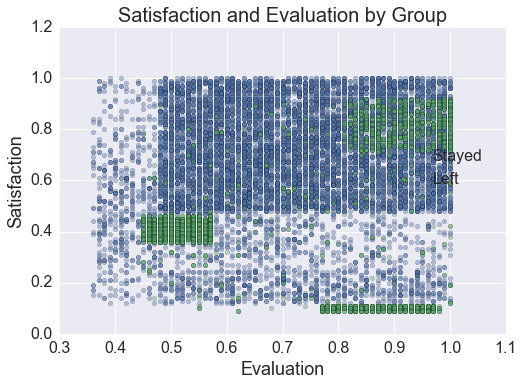

In [11]:
#sns.set(rc = snsdict)
plt.rcParams.update(pltdict)
stayed = plt.scatter(x = data.Evaluation[data.Left == 0], y = data.Satisfaction[data.Left == 0], 
                     c= current_palette[0], alpha = .4);
left = plt.scatter(x = data.Evaluation[data.Left == 1], y = data.Satisfaction[data.Left == 1], 
                   c= current_palette[1], alpha = .4)
plt.xlabel("Evaluation"); plt.ylabel("Satisfaction");
plt.title("Satisfaction and Evaluation by Group");
leg = plt.legend((stayed,left), ("Stayed","Left"),fontsize=16, bbox_to_anchor=(.98, .65));
for lh in leg.legendHandles: lh.set_alpha(1)

Here we see some interesting patterns in the data. There seem to be very distinct chunks of data separated by these two variables. This could possibly be due to how the data were simulated (maybe at some point there was some censoring?). 

These graphs also suggest the possibility of an interaction (or 'synergy') effect between satisfaction and evaluation.  It may be helpful to include this in our model.  Let's also take a look at whether we can see any patterns of errors in our original predictions based on this visualization setup.

AttributeError: 'NoneType' object has no attribute 'set_alpha'

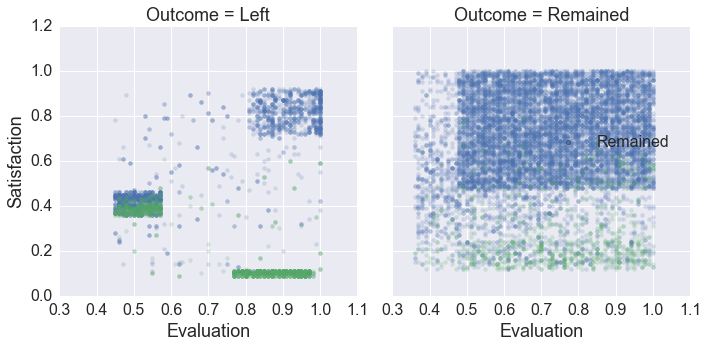

In [12]:
plt.rcParams.update(pltdict)
data['Predicted'] = ['Left' if pred else 'Remained' for pred in lr.predict(X)]
data['Outcome'] = ['Left' if left else 'Remained' for left in data.Left]
sns.lmplot(x = 'Evaluation', y = 'Satisfaction',hue = 'Predicted', 
           hue_order = ['Remained','Left'],col = 'Outcome', data = data, fit_reg=False,
            scatter_kws={'alpha':0.2}, legend = False);
leg = plt.legend((stayed,left), ("Remained","Left"),fontsize=16, bbox_to_anchor=(.98, .65));
for lh in leg.legendHandles: lh.set_alpha(1);
leg.set_title('Prediction')

The left plot above shows us true positives (green), and false negatives (blue).  Thus, the blue dots are the classification failures that led to our low recall/sensitivity metric.  We see two blocks of blue that we miss classified. An interaction effect between satisfaction and evaluation, along with other features, may help us account for these errors.

The right plot above shows us true negatives (blue), and false positives (green). We see that our false positives (green dots) are much more diffuse than our false negatives (blue on the left), and probably won't be able to be captured well by these two variables.

### Hours

In [ ]:
sns.set(rc = snsdict)
#plt.rcParams.update(pltdict)
fig, ax = plt.subplots(3,1, figsize = (15,18));
sns.barplot(data = data, x = 'Hours', y= 'Left', ax = ax[0], color = sns.xkcd_rgb["pale red"]);
sns.regplot(data = data, x = 'Hours', y= 'Left', y_jitter=.02,
            scatter_kws={'alpha':0.05, 'color':cols}, fit_reg = False, ax = ax[1]);
sns.barplot(data = data, x= 'Left', y = 'Hours', ax = ax[2]);
ax[0].set_ylabel('Proportion Leaving'); ax[0].set_xticklabels([])
ax[1].set_xlabel("Hours"); ax[1].set_yticks([0,1]); ax[1].set_yticklabels(['Stayed','Left']);
ax[1].set_ylabel('');
ax[2].set_xticklabels(['Stayed','Left']); ax[2].set_ylabel('Mean Hours / Month')
ax[2].set_xlabel("")
fig.tight_layout()

Once again, just like satisfaction and evaluation, we see a quadratic relationship between number of hours worked and retention.  People working the fewest and the most hours are the most likely to leave.

### Number of Projects
Sidenote: it may be difficult to know how to interpret this variable. It is unclear whether this represents: 

 - The number of projects a person is working on simultaneously. In this case, you would expect it to track with total hours worked, and possibly stress or satisfaction.
 -  The number of projects an employee has worked on during his or her tenure at the company. In this case, you would expect it to track with length of tenure.

Understanding what this variable means would be critical to choosing the appropriate actions for employee retention.

In [ ]:
plt.rcParams.update(pltdict)
fig, ax = plt.subplots(2,1, figsize = (10,13));
sns.barplot(data = data, x = 'Projects', y= 'Left', ax = ax[0]);
sns.barplot(data = data, y = 'Projects', x= 'Left', ax = ax[1]);
ax[0].set_xlabel("Number of Projects"); ax[0].set_ylabel("Proportion Leaving");
ax[0].set_title("Proportion of Employees Leaving by Number of Projects");
ax[1].set_xticklabels(['Stayed','Left']); ax[1].set_title("Average Number of Projects by Retention Status");
ax[1].set_ylabel("Average Number of Projects"); ax[1].set_xlabel("");
fig.tight_layout();

### Accidents, Salary, Promotion, and Tenure

In [ ]:
#sns.set(rc = snsdict)
plt.rcParams.update(pltdict)
fig, ax = plt.subplots(4,1, figsize = (10,15),sharey = True);
sns.barplot(data = data, x = 'Accident', y= 'Left', ax = ax[0]);
ax[0].set_xticklabels(['No Accident','Accident']); ax[0].set_xlabel('');
sns.barplot(data = data, x= 'Salary', y = 'Left', ax = ax[1]);
sns.barplot(data = data, x= 'Promotion', y = 'Left', ax = ax[2]);
ax[2].set_xticklabels(['No Promortion', 'Promotion']);ax[2].set_xlabel('');
sns.barplot(data = data, x= 'Tenure', y = 'Left', ax = ax[3]);
ax[3].set_xlabel('Tenure (years)')
for i in range(4): ax[i].set_ylabel('Proportion Leaving')
fig.tight_layout()

Here we see mostly linear trends except for Tenure, which may require a quadratic term.

## Summary

The baseline model may have assumed too many linear relationships between our employees' characteristics and their retention statuses. Based on these visualizations, we will most likely need second order terms for the following variables:

 - evaluation
 - projects
 - hours
 - tenure
 - satisfaction (this may require a cubic feature too)

It is likely that there are important interaction effects present among these variables (e.g., working long hours may have a different effect on probability of leaving if one is satisfied vs. unsatisfied with his or her job). So, we will include interaction terms in our feature engineering.

----------

# Part 3: Preprocessing and Feature Engineering

In [13]:
def newfeatures(data, polyfeats, modeldata = None, return_data = False):
    """Cleans data, computes new features, returns X and y
    In order to properly process simulated data, data = the data to be processed,
    modeldata = the raw training/development data from which the model was developed"""
    #if modeldata is None: modeldata = data  # then data is modeldata
    data = data.replace(['low','medium','high'], [1,2,3],axis=1)
    if modeldata is None:
        polyfit = preprocessing.PolynomialFeatures(2,include_bias = False).fit(data[polyfeats])
        dummyfit = preprocessing.LabelBinarizer().fit(data['Department'])
    else:
        modeldata = modeldata.replace(['low','medium','high'], [1,2,3],axis=1)
        polyfit = preprocessing.PolynomialFeatures(2,include_bias = False).fit(modeldata[polyfeats])
        dummyfit = preprocessing.LabelBinarizer().fit(modeldata['Department'])
    y = data['Left']
    X = (data.drop(['Left'], axis = 1)
         #.replace(['low','medium','high'], [1,2,3],axis=1)
         .merge(computePoly(data[polyfeats], polyfit), left_index=True, right_index=True)
         .merge(computeDummies(data['Department'], dummyfit), left_index=True, right_index = True)
         .assign(sat3 = lambda x: x.Satisfaction**3) # satisfaction third-order polynomial 
         .drop(['Department']+polyfeats,axis = 1))
    if return_data == True:
        return X
    X = scale(X, modeldata, polyfeats)
    return X, y
    
def scale(X, modeldata, polyfeats):
    scalerfit = get_scalerfit(X, modeldata, polyfeats)
    return pd.DataFrame(scalerfit.transform(X), columns = X.columns)

def get_scalerfit(X, modeldata, polyfeats):
    if modeldata is None:
        return preprocessing.StandardScaler().fit(X)
    else:
        X = newfeatures(modeldata, polyfeats, return_data = True)
        return preprocessing.StandardScaler().fit(X)
    
def computePoly(data, polyfit):
    output_nparray = polyfit.transform(data)
    target_feature_names = ['x'.join(['{}^{}'.format(pair[0],pair[1]) for pair in tuple if pair[1]!=0]) for tuple in [zip(data.columns,p) for p in polyfit.powers_]]
    return pd.DataFrame(output_nparray, columns = target_feature_names)

def computeDummies(data, dummyfit):
    return pd.DataFrame(dummyfit.transform(data), 
                               columns = dummyfit.classes_).iloc[:,:-1] # drop one dummy column

In [14]:
polyfeats = ['Satisfaction','Evaluation','Projects','Hours','Tenure','Salary']

X, y = newfeatures(data[orig_vars], polyfeats)

X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size = 0.2, random_state = 8)

----------

# Part 4: Logistic Regression Modeling 

### Train model and tune hyperparameters

In [15]:
## Tune hyperparameters
lrcv = LogisticRegressionCV(cv=5, random_state = 20)
lrcv.fit(X_train,y_train)
print('Optimal C = {0:.4f}'.format(lrcv.C_[0]))

Optimal C = 1291.5497


In [16]:
## Get cross validation score
lr = LogisticRegression(C = lrcv.C_[0], random_state=5)
lr.fit(X_train,y_train)
print('10-fold cross validation accuracy: {0:.2f}%'
      .format(np.mean(cross_val_score(lr, X_train, y_train,cv = 10))*100))

10-fold cross validation accuracy: 95.25%


This is great! We've improved our prediction by 15% by including these new features. More importantly, let's see if we've improved precision and recall.

Precision/Recall Table for Training Data: 

             precision    recall  f1-score   support

          0       0.97      0.97      0.97      9158
          1       0.90      0.90      0.90      2841

avg / total       0.95      0.95      0.95     11999



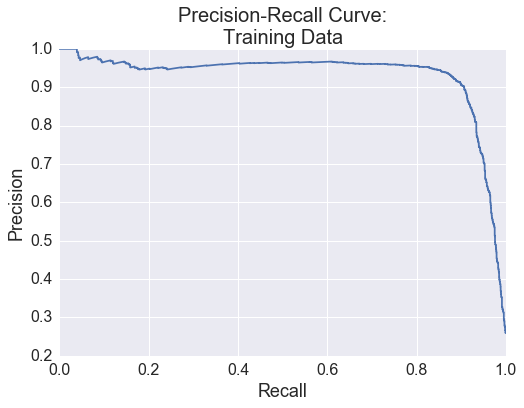

In [17]:
print('Precision/Recall Table for Training Data: \n')
print(classification_report(y_train, lr.predict(X_train)))
prc = precision_recall_curve(y_train, lr.decision_function(X_train), pos_label=1);
plt.plot(prc[1],prc[0]);
plt.xlabel('Recall');
plt.ylabel('Precision');
plt.title('Precision-Recall Curve:\nTraining Data');

This is a significant increase in precision (.61 --> .90) and recall (.37 --> .90).  So we've effectively reduced our false negative and false positive rates. Now let's see how we fare on our testing data.

### Model Evaluation on Test Data

In [18]:
print('Test accuracy: {0:.2f}%'.format(lr.score(X_test,y_test)*100))

Test accuracy: 95.30%


Precision/Recall Table for Test Data: 

             precision    recall  f1-score   support

          0       0.97      0.96      0.97      2270
          1       0.89      0.92      0.90       730

avg / total       0.95      0.95      0.95      3000



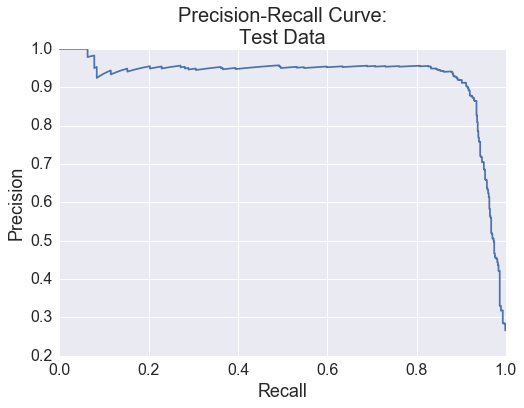

In [19]:
print('Precision/Recall Table for Test Data: \n')
print(classification_report(y_test, lr.predict(X_test)))
prc = precision_recall_curve(y_test, lr.decision_function(X_test), pos_label=1);
plt.plot(prc[1],prc[0]);
plt.xlabel('Recall');
plt.ylabel('Precision');
plt.title('Precision-Recall Curve:\nTest Data');

### Summary
Our model does a pretty good job at predicting the test data, with little-to-no signs of overfitting.  We're accurately classifying 95% of employees overall, and we're identifying 92% of people who are going to leave.

----------



# Part 5: Interpreting the Coefficients Using Simulations
Though my hope had originally been to develop a model that was still interpretable, the addition of multiple interaction effects and quadratic makes this very difficult (though not impossible).  Normally, we could simply look at the coefficients of the model to understand the relative impacts of different variables. But with quadratic terms and interaction effects, a change in a single variable requires changes to the higher order terms that that variable contributes to. Thus, we will be making some interpretations by simulating the data across different values of a few variables and visualizing how these combinations affect probability of leaving.


In [20]:
def simulate(x, row, col, data, SKLmodel):
    # simulate data at different levels of x, row, and col
    sim = pd.DataFrame(columns = data.columns)
    for q1 in data[row].quantile([.05,.30,.70,.95]).values:
        for q2 in data[col].quantile([.05,.30,.70,.95]).values:
            sim2 = pd.DataFrame(columns = data.columns).append(data.median(), ignore_index=True)
            sim2 = sim2.append([sim2]*99,ignore_index=True)
            sim2[x] = np.linspace(data[x].min(), data[x].max(), 100)
            sim2[col] = q2
            sim2[row] = q1
            sim = sim.append(sim2, ignore_index = True)
    sim2 = sim.assign(Department = 'IT').assign(Salary = 'low')
    sim = sim.assign(Department = 'IT').assign(Salary = 'high').append(sim2, ignore_index = True)
    Xsim, _ = newfeatures(sim, polyfeats, data)
    
    # generate probabilities using model, add to DF
    probs = SKLmodel.predict_proba(Xsim)
    sim['Probability'] = probs[:,1]
    
    # Plot
    sns.set(style="white", 
            rc = {'axes.titlesize' : 20,
            'axes.labelsize' : 20,
            'xtick.labelsize' : 20,
            'ytick.labelsize' : 20,
            'figure.titlesize': 40})
    grid = sns.FacetGrid(sim, col=col, row=row, hue="Salary", size = 5) # initialize grid
    grid.map(plt.axhline, y=.5, ls=":", c=".5")     # P = .5 horizontal line
    grid.map(plt.plot, x, 'Probability', ls = '-',linewidth = 4) # draw lines
    ## NOTE: make sure the lines for the main variables are plotted LASt, other wise labels will be changed
    grid.set(yticks=[], ylim = (0,1)) #  remove y ticks
    grid.fig.tight_layout(w_pad = 1) # arrangement
    plt.subplots_adjust(top=0.9) # space for title
    grid.fig.suptitle('Probability of leaving by {0}, {1}, and {2}'.format(x,row,col)) # title

## NOTES: For all the graphs below:
-  Each row/column of plots represents 4 quantiles from the observed data: 5%ile, 30%ile, 70%ile, and 95%ile.
- Low salary = green, and high salary = blue
- Estimates are based on an IT worker. Based on our model, switching departments might raise or lower the lines, but won't change their shape. HR will generally have higher probability of leaving, whereas management will be lower.

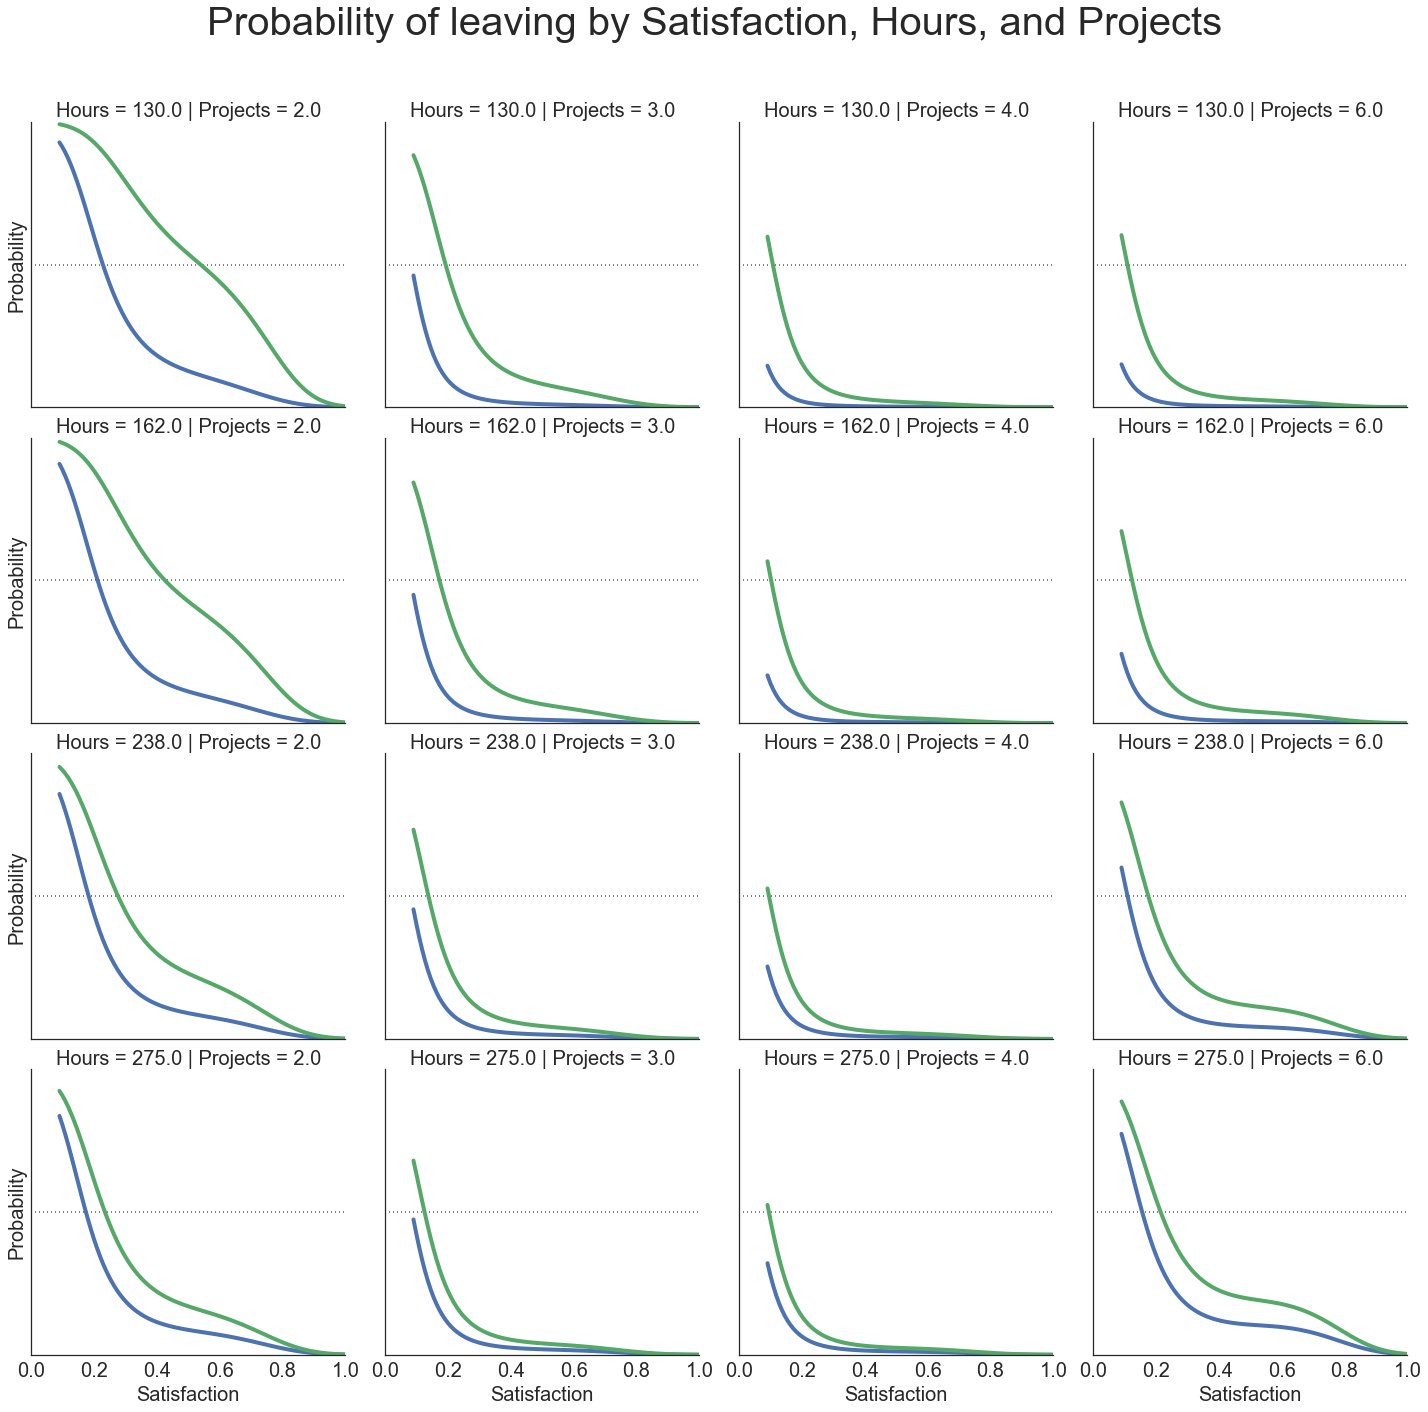

In [21]:
data = data[orig_vars]
x, r, c = 'Satisfaction, Hours, Projects'.split(', ')
simulate(x, r, c, data, lr)

 - Very low satisfaction is consistently associated with higher churn, but especially at at the lowest and highest levels of company involvement (indicated by hours and projects, see upper left and lower right plots). At the very highest level of company involvement, satisfaction is protective against leaving.
 - Salary makes the biggest difference at low levels of satisfaction and company involvement, but at higher levels of involvement and satisfaction, salary makes less of a difference.

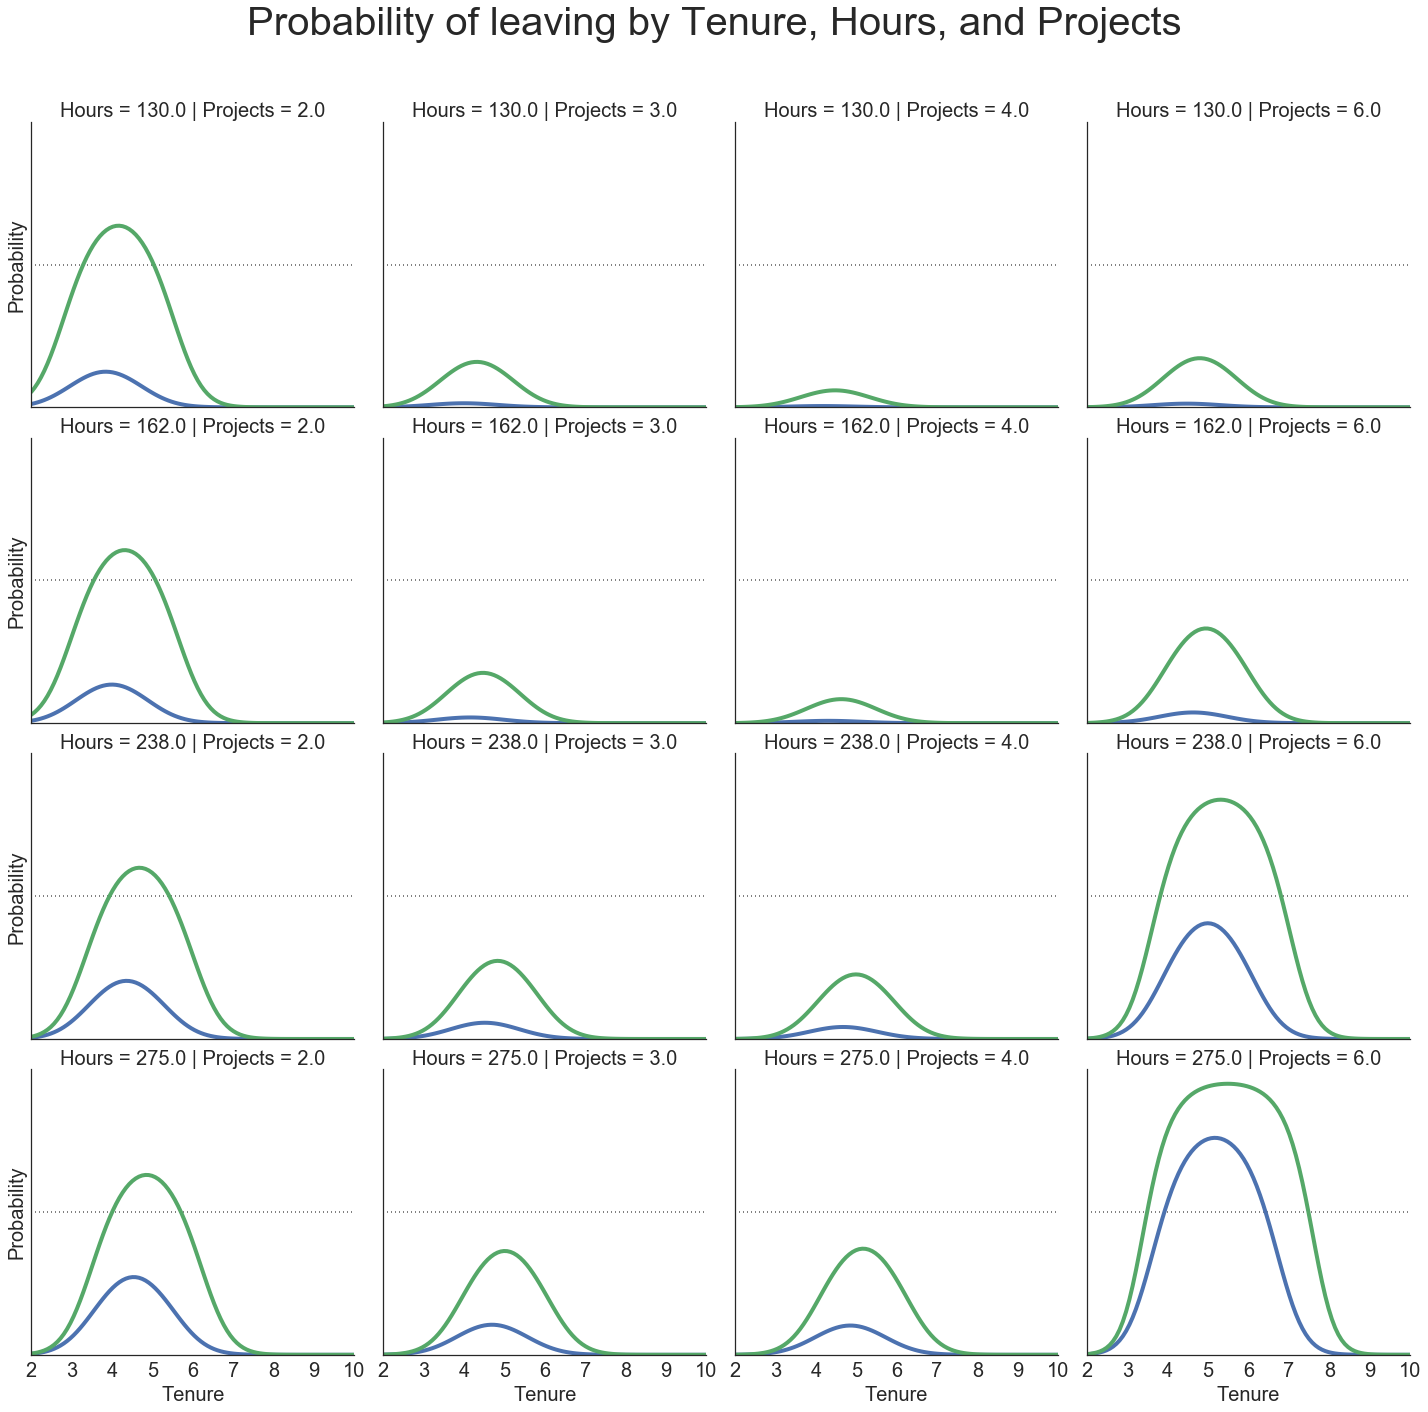

In [22]:
x, r, c = 'Tenure, Hours, Projects'.split(', ')
simulate(x, r, c, data, lr)

- On it's own, tenure rarely makes someone HIGHLY likely to leave, though it appears the highest risk for leaving is between 4-6 years (a bit earlier if a person is underworked).
- The risk during this period is higher when an employee is over-worked, or has very few projects under his/her belt. But even then, after 6 years, everyone is highly likely to stay. 
- Salary here makes an important difference: A high-salaried person is more likely to leave than to stay only at the highest levels of company involvement (hours and projects). On the other hand, low-paid employee are likely to leave after only a few years, and then it tapers off after that. However, if a low-paid employee is over-worked, they  are likely to leave at any point in their tenure.  In other words: if you're going to work someone hard, it's a good idea to pay them more (duh!)

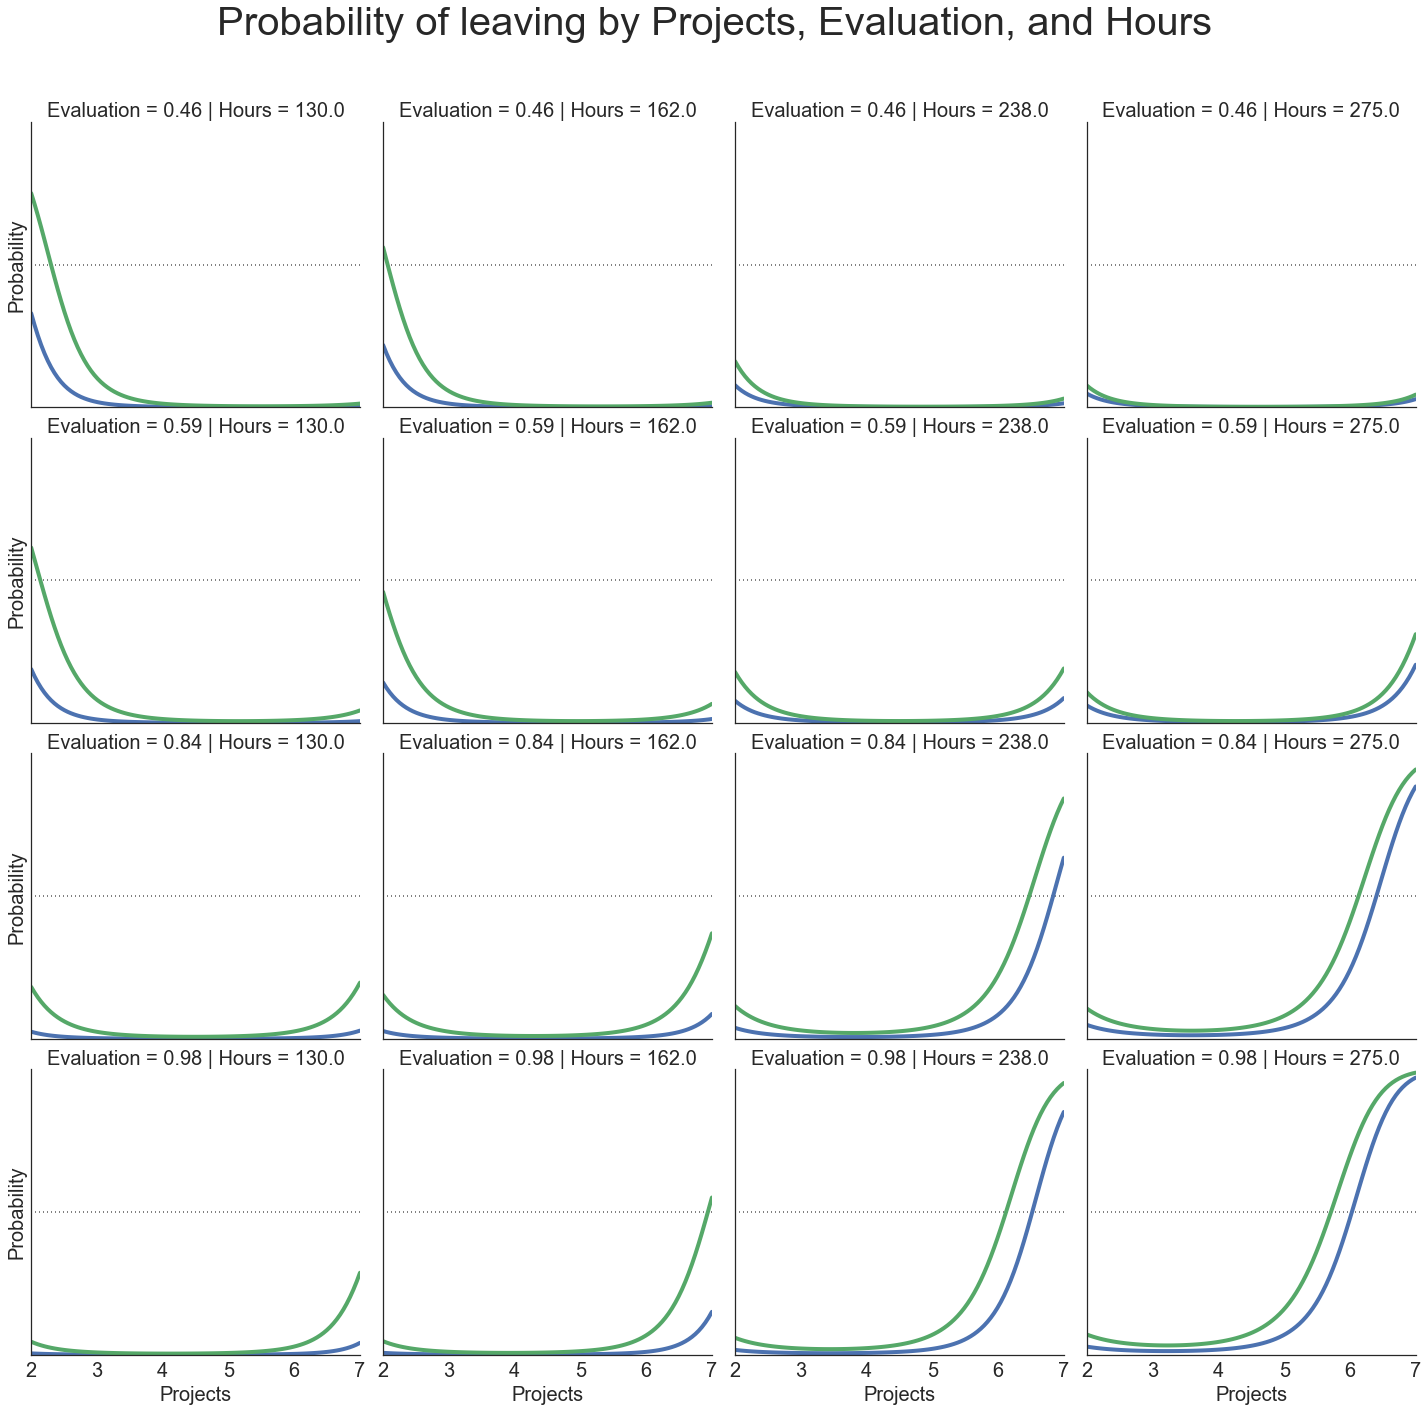

In [23]:
x, r, c = 'Projects, Evaluation, Hours'.split(', ')
simulate(x, r, c, data, lr)

 - This graph gives us a little different perspective on projects: There appears to be some threshold around 6 projects after which a person is very likely to leave, particularly if they are working above the median # hours and evaluation. Salary makes little difference here.  Since these are employees who are good at their jobs (by virtue of higher evaluation scores), they may be leaving because they are overworked and have the power to attract offers from other companies.


____________________________
 
 


# Summary and Conclusions

There doesn't appear to be any single diagnostic factor that can predict churn (except maybe # of projects = 7+), but rather a combination of various factors. Interestingly, there appears to be consistent "sweet spots" in which churn is low.  That is to say, being underworked is just as much of a problem as being overworked. With the exception of "Tenure", the lowest levels of attrition seem to occur right in the middle range of possible values for each variable; and conversely, highest rates of attrition are on one or both tails. With a more graphs and explorations, one could gain a deeper understanding of the main factors (or better, combinations of factors) contributing to churn, but this will suffice here.

----------



# Appendix: Just for fun, a quick prediction comparison to SVM

In [24]:
from sklearn.svm import SVC
X2, y2 = process(data[orig_vars])
X2_train, X2_test, y2_train, y2_test = train_test_split(
            X2, y2, test_size = 0.1, random_state = 50)
clf = SVC()
clf.fit(X2_train, y2_train) 
print('Prediction accuracy on test data with no feature engineering: ',clf.score(X = X2_test, y = y2_test))
X2, y2 = newfeatures(data[orig_vars], polyfeats)
X2_train, X2_test, y2_train, y2_test = train_test_split(
            X2, y2, test_size = 0.1, random_state = 50)
clf = SVC(probability=True)
clf.fit(X2_train, y2_train) 
print('Prediction accuracy on test data WITH feature engineering: ',clf.score(X = X2_test, y = y2_test))

('Prediction accuracy on test data with no feature engineering: ', 0.95066666666666666)
('Prediction accuracy on test data WITH feature engineering: ', 0.95799999999999996)


**Even without adding features, we can get 95% prediction accuracy with SVM, and adding features does little improve!!   And this is before tuning hyper parameters! But can we interpret the model?  Not really, but we could run simulations as we did with Logistic Regressions.** 




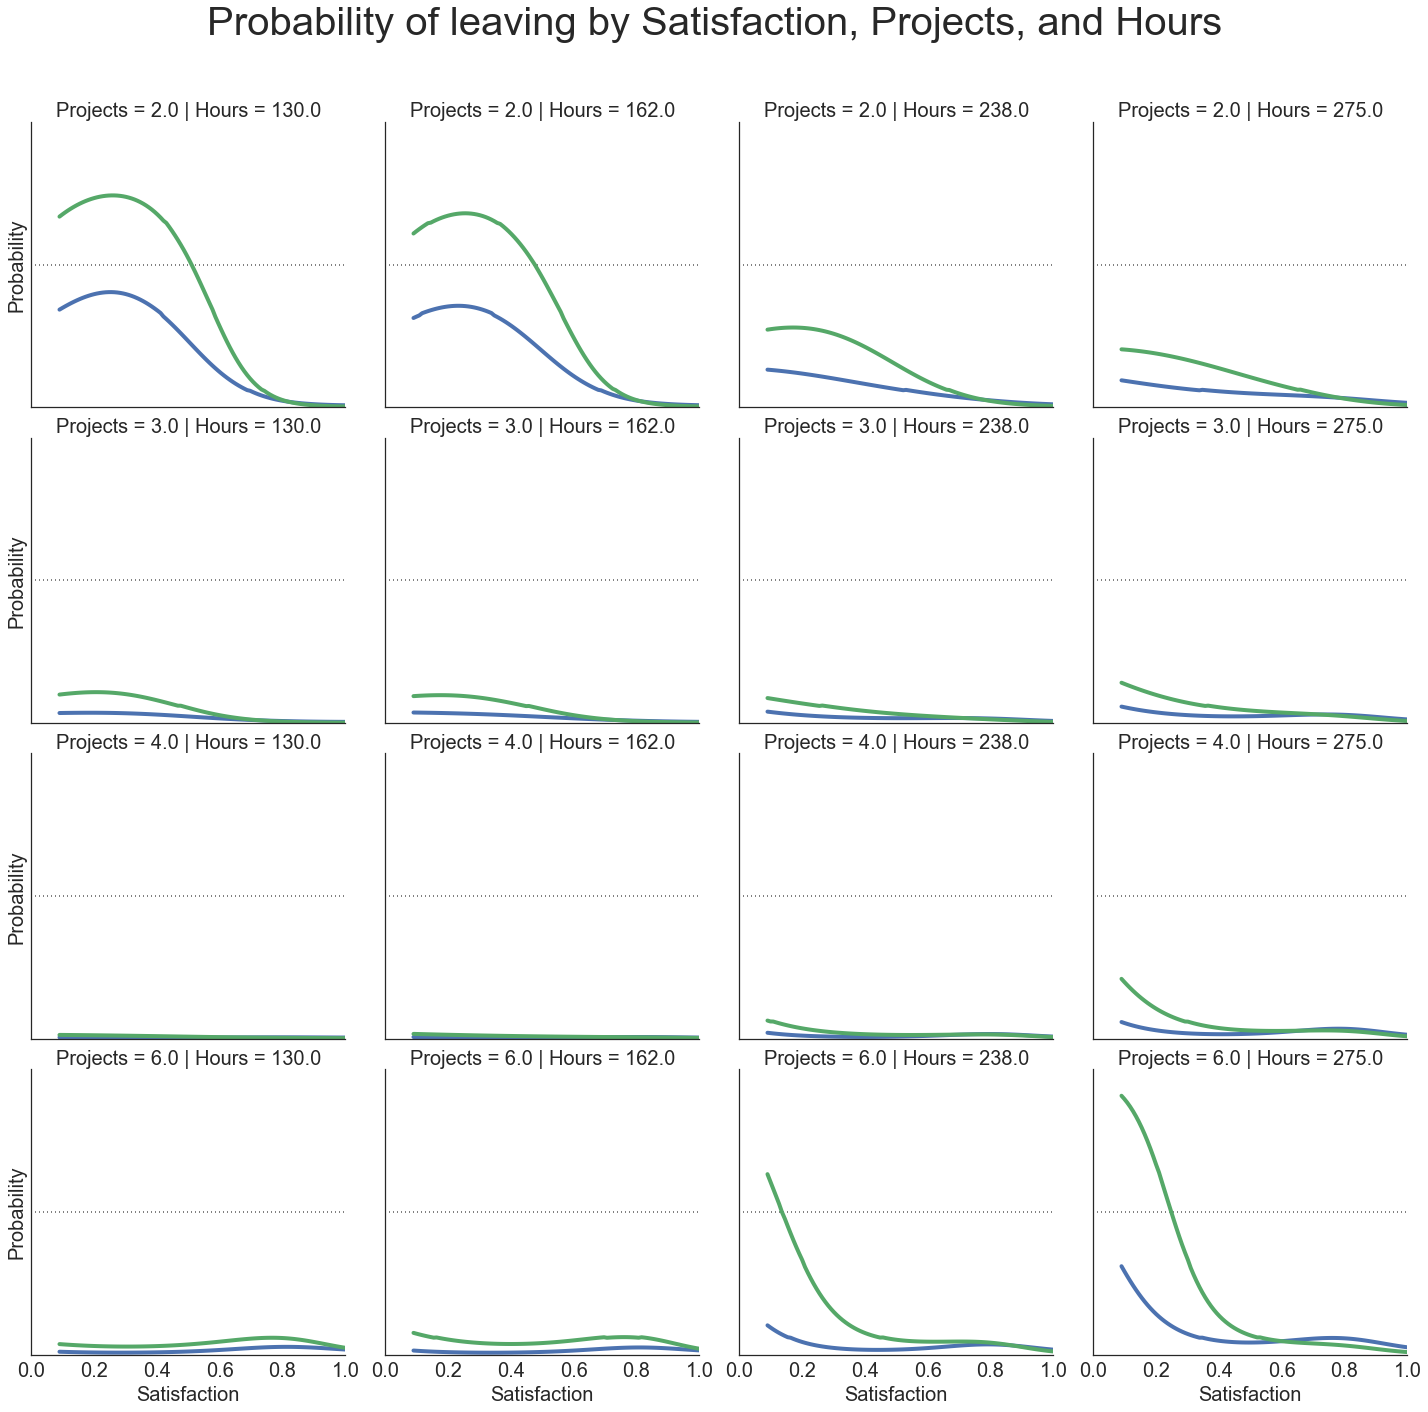

In [25]:
x, r, c = 'Satisfaction, Projects, Hours'.split(', ')
g = simulate(x, r, c, data, clf)

The predictions are a bit different from the first grid of plots in simulating our logistic regression model. In particular, the bottom right corner graph drops off more quickly from left to right.  And most of the plots in the middle here are more flat; they don't have the little tail at lower levels of satisfaction. 




----------
